In [255]:
import datetime
import os
import random
import readline
from datetime import date
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import netCDF4
import numpy
import pandas
import scipy
import seaborn
import xarray as xr
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from matplotlib import colors, font_manager, pyplot
from matplotlib.cm import ScalarMappable
from mpl_toolkits.mplot3d import Axes3D
from netCDF4 import Dataset
from PIL import Image
from scipy import fft, linalg, stats
from scipy.stats import poisson, ttest_ind
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import normalize
from statsmodels.tsa.ar_model import AutoReg

In [256]:
Diri = "/glade/u/home/whimkao//ExtraTrack/Output_Files/"

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri + Model + "_Data_Output_V5.csv")
    ET_DF = Open_File(Diri + Model + "_ET_Output_V5.csv")
    Codes_DF = Open_File(Diri + Model + "_Codes_Output_V5.csv")
    Time = []
    Start_Time = []
    End_Time = []
    # Edit Time Format
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Start_Time.append(Datetime(ET_DF["Start Time"][j]))
        End_Time.append(Datetime(ET_DF["End Time"][j]))
    Data_DF["Time(Z)"] = Time
    ET_DF["Start Time"] = Start_Time
    ET_DF["End Time"] = End_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    New_Time = datetime.datetime.strptime(Time, "%Y-%m-%d %H:%M:%S")
    return (New_Time)

In [6]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri)

In [7]:
# Find a Specific Storm Within the DataFrame
def Find_Storm(DF, Code):
    DF_Storm = DF[DF["Code"] == Code].reset_index()
    return (DF_Storm)

In [8]:
# Create Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max + Bin_Width, Bin_Width)
    return (Bins)

In [9]:
# Function to Find Distance Between Two Points
def Find_Distance(y1, y2, x1, x2):
    Start_Lat = y1 * numpy.pi / 180
    End_Lat = y2 * numpy.pi / 180
    Start_Lon = x1 * numpy.pi / 180
    End_Lon = x2 * numpy.pi / 180
    Lat_Diff = End_Lat - Start_Lat
    Lon_Diff = End_Lon - Start_Lon
    Earth_Rad = 6378
    Distance = (2 * Earth_Rad * numpy.sqrt((numpy.sin(Lat_Diff / 2)) ** 2 + \
    numpy.cos(Start_Lat) * numpy.cos(End_Lat) * (numpy.sin(Lon_Diff / 2)) ** 2))
    return (Distance)

In [10]:
# Create Function to Open Storm Composite Files
def Composite_File(File):
    Diri = "/glade/work/whimkao//ExtraTrack/Composite_Files_V5/"
    Compo_File = xr.open_dataset(Diri + File)
    return Compo_File

In [11]:
# Open Storm Composite Files
Control_A_Compo_nc = Composite_File("composite_dtime900.control.002.nc")
Control_B_Compo_nc = Composite_File("composite_dtime900.control.003.nc")
Control_C_Compo_nc = Composite_File("composite_dtime900.control.004.nc")

In [12]:
# Open Storm Composite Files
RCP45_A_Compo_nc = Composite_File("composite_dtime900.rcp45.001.nc")
RCP45_B_Compo_nc = Composite_File("composite_dtime900.rcp45.002.nc")
RCP45_C_Compo_nc = Composite_File("composite_dtime900.rcp45.003.nc")

In [13]:
# Open Storm Composite Files
RCP85_A_Compo_nc = Composite_File("composite_dtime900.rcp85.001.nc")
RCP85_B_Compo_nc = Composite_File("composite_dtime900.rcp85.003.nc")
RCP85_C_Compo_nc = Composite_File("composite_dtime900.rcp85.004.nc")

In [14]:
# Create DataFrame With Lat Lon Time Data of the Composite Files
def Composite_DF(Compo_nc, ABC):
    Snap_Time = pandas.Series(Compo_nc.snap_time)
    Snap_Lon = pandas.Series(Compo_nc.snap_lon) - 360.0
    Snap_Lat = pandas.Series(Compo_nc.snap_lat)
    Snap_PathID = pandas.Series(Compo_nc.snap_pathid)
    Index = numpy.arange(0,len(Snap_Time),1)
    ABC_List = []
    for m in range(len(Index)):
        ABC_List.append(ABC)
    Compo_DF = pandas.DataFrame({"Orig Index": Index, "ABC": ABC_List, "Time": Snap_Time, \
    "Lon": Snap_Lon, "Lat": Snap_Lat, "PathID": Snap_PathID})
    return (Compo_DF)

In [15]:
# Combine Composite DFs
def Combine_Compo_DF(Compo_A, Compo_B, Compo_C):
    Compo_DF_A = Composite_DF(Compo_A, "A")
    Compo_DF_B = Composite_DF(Compo_B, "B")
    Compo_DF_C = Composite_DF(Compo_C, "C")
    Compo_DF = pandas.concat([Compo_DF_A, Compo_DF_B, Compo_DF_C]).reset_index()
    Compo_DF = Compo_DF.drop("index", axis=1)
    return (Compo_DF)

In [16]:
#Control_Compo = Combine_Compo_DF(Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc)

In [17]:
#RCP45_Compo = Combine_Compo_DF(RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc)

In [18]:
#RCP85_Compo = Combine_Compo_DF(RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc)

In [19]:
# Change Year of Data
def Reverse_Update_Year(New_Time, Year_Diff):
    Year_Orig = New_Time.year + Year_Diff
    Orig_Time = New_Time.replace(year=Year_Orig)
    return Orig_Time

In [20]:
# Create Function to Find Year Diff
def Year_Diff_Find(New_Time):
    Years = [1900, 1930, 1960, 2000, 2031, 2062, 2100, 2131, 2162, 2193]
    New_Time_Index = -728
    for i in range(len(Years)):
        if i < 3:
            if New_Time.year >= Years[i] and New_Time.year < Years[i + 1]:
                Year_Diff = 1985 - Years[i]
                New_Time_Index = i
        elif i < 6:
            if New_Time.year >= Years[i] and New_Time.year < Years[i + 1]:
                Year_Diff = 2070 - Years[i]
                New_Time_Index = i
        else:
            if New_Time.year >= Years[i] and New_Time.year < Years[i + 1]:
                Year_Diff = 2070 - Years[i]
                New_Time_Index = i
    if New_Time_Index % 3 == 0:
        ABC = "A"
    elif New_Time_Index % 3 == 1:
        ABC = "B"
    elif New_Time_Index % 3 == 2:
        ABC = "C"
    return (int(Year_Diff), ABC)

In [21]:
# Create Function to Find Indexes of Composite Data For Selected Storm
def Find_Composite_Data(Code, Data_DF, Compo_DF):
    DF_Storm = Find_Storm(Data_DF, Code)
    New_Time = DF_Storm["Time(Z)"]
    Lat = DF_Storm["Lat"]
    Lon = DF_Storm["Lon"]
    SLP = DF_Storm["SLP(hPa)"]
    Windspeed = DF_Storm["Winds(m/s)"]
    B = DF_Storm["B"]
    VLT = DF_Storm["VLT"]
    VUT = DF_Storm["VUT"]
    Storm_Phase = DF_Storm["Storm Phase"]
    Compo_Indexes = numpy.zeros(len(New_Time))
    Codes = []
    for i in range(len(New_Time)):
        Codes.append(Code)
        Year_Diff, ABC = Year_Diff_Find(New_Time[0])
        Orig_Time = Reverse_Update_Year(New_Time[i], Year_Diff)
# Find Possible Storms that Occur at the Same Time
        Compo_Storm = Compo_DF[(Compo_DF["ABC"] == ABC) & (Compo_DF["Time"] == Orig_Time)].reset_index()
# If No Storm Found:
        if len(Compo_Storm) == 0:
            Compo_Indexes[i] = -728
# Storms Found:
        else:
            Dist_Min = [7428, -728]
            for c in range(len(Compo_Storm)):
                Dist = Find_Distance(Lat[i], Compo_Storm["Lat"][c], Lon[i], Compo_Storm["Lon"][c])
# Find Storm Closest to Storm Center
                if Dist < Dist_Min[0]:
# At Most 300km of Error in Location Permitted
                    if Dist < 300:
                        Dist_Min = [Dist, Compo_Storm["Orig Index"][c]]
                    else:
                        Dist_Min = [Dist, -728]
            Compo_Indexes[i] = Dist_Min[1]
    DF_Storm_Compo_Init = pandas.DataFrame({"Code": Codes, "Compo Index": Compo_Indexes, "Time": New_Time, \
    "Lon": Lon, "Lat": Lat, "SLP(hPa)": SLP, "Winds(m/s)": Windspeed, "B": B, "VLT": VLT, "VUT": VUT, \
    "Storm Phase": Storm_Phase})
# Remove Datapoints With Missing Compo Index
    DF_Storm_Compo = DF_Storm_Compo_Init[DF_Storm_Compo_Init["Compo Index"] >= 0].reset_index()
    DF_Storm_Compo = DF_Storm_Compo.drop("index", axis=1)
    return (DF_Storm_Compo)

In [22]:
def Windspeed_850hPa(Compo_nc, Compo_Index):
    U850 = numpy.array(Compo_nc.snap_U850[int(Compo_Index)])
    V850 = numpy.array(Compo_nc.snap_V850[int(Compo_Index)])
    Snap_850 = numpy.sqrt(U850**2 + V850**2)
    return Snap_850

In [23]:
def R_Max_Find(Windspeed_Snap, x_Snap, y_Snap, Lat, Lon):
    Max_Windspeed = numpy.max(Windspeed_Snap)
    Max_Locs = numpy.where(Windspeed_Snap >= (Max_Windspeed * 0.95))
    Dist_Final = 7428
    for m in range(len(Max_Locs[0])):
        x_Diff = x_Snap[Max_Locs[0][m]]
        y_Diff = y_Snap[Max_Locs[1][m]]
        Dist = Find_Distance(Lat, y_Diff + Lat, Lon, x_Diff + Lon)
        if Dist < Dist_Final:
            Dist_Final = Dist
    return (Dist_Final, Max_Windspeed)

In [24]:
# Find 850hPa Max Windspeed and Wind Field Size at Each 6 Hourly Data Point
def Wind_Field_Find_850hPa(DF_Storm_Compo, Compo_nc):
    Compo_Index = DF_Storm_Compo["Compo Index"]
    Time_List = DF_Storm_Compo["Time"]
    SLP = DF_Storm_Compo["SLP(hPa)"]
    Windspeed = DF_Storm_Compo["Winds(m/s)"]
    Lat = DF_Storm_Compo["Lat"]
    Lon = DF_Storm_Compo["Lon"]
    x_Snap = Compo_nc.x
    y_Snap = Compo_nc.y
#
# Create Array to Store Data
    Wind_Field_Info = numpy.zeros((7, len(Compo_Index)))
    Wind_Field_Info[0] = SLP
    Wind_Field_Info[1] = Windspeed
#
# At Each 6 Hourly Data Point
    for k in range(len(Compo_Index)):
# Find 850hPa Windspeed Snap From Compo_nc
        Snap_850 = Windspeed_850hPa(Compo_nc, Compo_Index[k])
        Count_18 = 0
        Count_25 = 0
        Count_33 = 0
#
# Count Number of Data Points With Windspeed Above 18,25,33m/s
        for i in range(len(Snap_850)):
            for j in range(len(Snap_850[0])):
                if Snap_850[i][j] >= 18:
                    Count_18 += 1
                if Snap_850[i][j] >= 25:
                    Count_25 += 1
                if Snap_850[i][j] >= 33:
                    Count_33 += 1
        Wind_Field_Info[2][k] = Count_18
        Wind_Field_Info[3][k] = Count_25
        Wind_Field_Info[4][k] = Count_33
#
# Find Distance Between Max Windspeed Point and Storm Center
#        R_Max, Max_Windspeed = R_Max_Find(Snap_850, x_Snap, y_Snap, Lat[k], Lon[k])
#        Wind_Field_Info[5][k] = R_Max
#        Wind_Field_Info[6][k] = Max_Windspeed
#
# Add Wind Field Info Into DF Storm Compo
    DF_Storm_Compo_Wind_Field = DF_Storm_Compo.copy()
    DF_Storm_Compo_Wind_Field["850hPa 18m/s"] = Wind_Field_Info[2]
    DF_Storm_Compo_Wind_Field["850hPa 25m/s"] = Wind_Field_Info[3]
    DF_Storm_Compo_Wind_Field["850hPa 33m/s"] = Wind_Field_Info[4]
#    DF_Storm_Compo_Wind_Field["850hPa R Max"] = Wind_Field_Info[5]
#    DF_Storm_Compo_Wind_Field["850hPa Winds"] = Wind_Field_Info[6]
    return (Wind_Field_Info, DF_Storm_Compo_Wind_Field)

In [25]:
# Find Wind Field Composite Data
#Code = "TC191304"
#Storm_Name = "Melody"
#Data_DF = Control_Data
#ET_DF = Control_ET
#Compo_DF = Control_Compo
#Compo_nc = Control_A_Compo_nc
#DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
#Wind_Field_Info_850, DF_Storm_Compo_850 = Wind_Field_Find_850hPa(DF_Storm_Compo, Compo_nc)
#DF_Storm_Compo_850

In [26]:
# Loop Through Every Storm
def Wind_Field_Storms(Data_DF, ET_DF, Compo_DF, Codes_DF, Compo_nc_A, Compo_nc_B, Compo_nc_C):
    Code_List = Codes_DF["New Code"]
    ABC_List = Codes_DF["ABC"]
# For Every Storm in Dataset
    for n in range(len(Code_List)):
        DF_Storm_Compo = Find_Composite_Data(Code_List[n], Data_DF, Compo_DF)
# Find Which Compo nc To Use
        if ABC_List[n] == "A":
            Compo_nc = Compo_nc_A
        elif ABC_List[n] == "B":
            Compo_nc = Compo_nc_B
        elif ABC_List[n] == "C":
            Compo_nc = Compo_nc_C
# Apply Functions For Finding Wind Field Size
        Wind_Field_Info_850, DF_Storm_Compo_850 = Wind_Field_Find_850hPa(DF_Storm_Compo, Compo_nc)
        if n == 0:
            DF_Compo_Combine = DF_Storm_Compo_850.copy()
        else:
            DF_Compo_Combine = pandas.concat([DF_Compo_Combine, DF_Storm_Compo_850])
        DF_Compo_Final = DF_Compo_Combine.reset_index().drop("index", axis=1)
    return (DF_Compo_Final)

In [27]:
#DF_Compo_Control = Wind_Field_Storms(Control_Data, Control_ET, Control_Compo, Control_Codes, \
#Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc)

,Code,Compo Index,Time,Lon,Lat,SLP(hPa),Winds(m/s),B,VLT,VUT,Storm Phase,850hPa 18m/s,850hPa 25m/s,850hPa 33m/s
0,TC190001,0.0,1900-06-19 12:00:00,-82.19,27.99,1015.45,13.9,4.71,37.04,-36.64,Tropical,149.0,0.0,0.0
1,TC190001,1.0,1900-06-19 18:00:00,-82.26,27.79,1015.45,13.8,6.18,-12.97,-23.15,Tropical,69.0,0.0,0.0
2,TC190001,2.0,1900-06-20 00:00:00,-82.33,27.58,1015.45,13.7,3.28,-8.22,-18.60,Tropical,23.0,0.0,0.0
3,TC190001,3.0,1900-06-20 06:00:00,-82.40,27.38,1015.45,13.7,3.45,-0.38,-18.54,Tropical,21.0,0.0,0.0
4,TC190001,4.0,1900-06-20 12:00:00,-82.46,28.31,1014.22,11.7,1.72,8.23,-4.21,Tropical,13.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12588,TC198902,10447.0,1989-09-28 18:00:00,-5.25,46.00,1016.56,10.2,31.29,-180.49,-149.36,Extratropical,1.0,0.0,0.0
12589,TC198902,10448.0,1989-09-29 00:00:00,-2.50,46.00,1018.02,8.4,26.75,-192.50,-150.26,Extratropical,0.0,0.0,0.0
12590,TC198902,10449.0,1989-09-29 06:00:00,-1.50,46.25,1017.76,7.6,22.77,-200.64,-148.95,Extratropical,0.0,0.0,0.0
12591,TC198902,10450.0,1989-09-29 12:00:00,-0.25,47.00,1018.13,9.1,21.04,-202.06,-149.32,Extratropical,0.0,0.0,0.0


In [28]:
#DF_Compo_RCP45 = Wind_Field_Storms(RCP45_Data, RCP45_ET, RCP45_Compo, RCP45_Codes, \
#RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc)

,Code,Compo Index,Time,Lon,Lat,SLP(hPa),Winds(m/s),B,VLT,VUT,Storm Phase,850hPa 18m/s,850hPa 25m/s,850hPa 33m/s
0,TC200004,45.0,2000-03-13 12:00:00,-60.26,38.00,988.78,31.5,37.71,38.56,-153.42,Tropical,372.0,29.0,0.0
1,TC200004,46.0,2000-03-13 18:00:00,-58.66,38.71,984.16,32.7,31.49,105.19,-20.60,Tropical,653.0,159.0,4.0
2,TC200004,47.0,2000-03-14 00:00:00,-57.80,40.41,978.97,29.9,22.22,127.52,-16.53,Tropical,936.0,218.0,17.0
3,TC200004,48.0,2000-03-14 06:00:00,-58.30,41.43,975.17,27.7,16.81,159.47,-7.55,Tropical,1210.0,274.0,3.0
4,TC200004,49.0,2000-03-14 12:00:00,-58.07,41.52,974.18,30.3,13.58,184.57,10.71,Tropical,1345.0,390.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7544,TC209110,7415.0,2091-11-06 06:00:00,-40.34,41.65,1014.15,21.0,15.50,4.29,-48.96,Transition,1751.0,503.0,22.0
7545,TC209110,7416.0,2091-11-06 12:00:00,-38.28,42.86,1014.03,23.3,17.09,-23.18,-56.19,Extratropical,1628.0,418.0,6.0
7546,TC209110,7417.0,2091-11-06 18:00:00,-35.00,44.25,1014.46,28.9,16.55,-43.52,-63.11,Extratropical,1590.0,551.0,17.0
7547,TC209110,7418.0,2091-11-07 00:00:00,-31.50,46.00,1015.90,23.7,17.13,-58.83,-67.57,Extratropical,1453.0,637.0,70.0


In [29]:
#DF_Compo_RCP85 = Wind_Field_Storms(RCP85_Data, RCP85_ET, RCP85_Compo, RCP85_Codes, \
#RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc)

,Code,Compo Index,Time,Lon,Lat,SLP(hPa),Winds(m/s),B,VLT,VUT,Storm Phase,850hPa 18m/s,850hPa 25m/s,850hPa 33m/s
0,TC210003,25.0,2100-03-01 00:00:00,-47.15,41.53,953.85,43.3,53.39,120.75,-47.77,Tropical,2501.0,1077.0,344.0
1,TC210003,26.0,2100-03-01 06:00:00,-45.10,44.65,944.96,41.6,21.05,202.41,206.43,Tropical,2601.0,1103.0,404.0
2,TC210003,27.0,2100-03-01 12:00:00,-45.04,45.78,943.01,34.9,15.07,185.73,208.32,Tropical,3283.0,1183.0,231.0
3,TC210003,28.0,2100-03-01 18:00:00,-44.74,46.27,944.13,33.5,4.69,170.02,205.68,Tropical,3987.0,989.0,171.0
4,TC210003,29.0,2100-03-02 00:00:00,-44.30,46.37,947.03,31.6,0.23,166.41,203.28,Tropical,3541.0,1080.0,68.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8434,TC219207,6173.0,2192-09-15 12:00:00,-52.75,37.25,1011.91,22.7,14.86,54.66,-55.23,Transition,0.0,0.0,0.0
8435,TC219207,6174.0,2192-09-15 18:00:00,-52.25,37.50,1013.48,21.2,12.03,22.90,-53.49,Transition,0.0,0.0,0.0
8436,TC219207,6175.0,2192-09-16 00:00:00,-51.50,37.50,1016.34,19.0,10.41,-6.23,-50.82,Extratropical,0.0,0.0,0.0
8437,TC219207,6176.0,2192-09-16 06:00:00,-51.25,37.75,1017.06,17.4,8.79,-20.07,-50.33,Extratropical,2.0,0.0,0.0


In [30]:
# Open File
def Open_File_2(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    Time = []
    for i in range(len(DF)):
        Time.append(Datetime(DF["Time"][i]))
    DF["Time"] = Time
    return (DF)

In [46]:
# Open Output Files Created From Last Time
Output_Diri = '/glade/u/home/whimkao//ExtraTrack/Output_Files_V5.4/'
DF_Compo_Control = Open_File_2(Output_Diri + "Control_Wind_Field_Info.csv")
DF_Compo_RCP45 = Open_File_2(Output_Diri + "RCP4.5_Wind_Field_Info.csv")
DF_Compo_RCP85 = Open_File_2(Output_Diri + "RCP8.5_Wind_Field_Info.csv")
DF_Compo_RCP85

,Code,Compo Index,Time,Lon,Lat,SLP(hPa),Winds(m/s),B,VLT,VUT,Storm Phase,850hPa 18m/s,850hPa 25m/s,850hPa 33m/s
0,TC210003,25.0,2100-03-01 00:00:00,-47.15,41.53,953.85,43.3,53.39,120.75,-47.77,Tropical,2501.0,1077.0,344.0
1,TC210003,26.0,2100-03-01 06:00:00,-45.10,44.65,944.96,41.6,21.05,202.41,206.43,Tropical,2601.0,1103.0,404.0
2,TC210003,27.0,2100-03-01 12:00:00,-45.04,45.78,943.01,34.9,15.07,185.73,208.32,Tropical,3283.0,1183.0,231.0
3,TC210003,28.0,2100-03-01 18:00:00,-44.74,46.27,944.13,33.5,4.69,170.02,205.68,Tropical,3987.0,989.0,171.0
4,TC210003,29.0,2100-03-02 00:00:00,-44.30,46.37,947.03,31.6,0.23,166.41,203.28,Tropical,3541.0,1080.0,68.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8434,TC219207,6173.0,2192-09-15 12:00:00,-52.75,37.25,1011.91,22.7,14.86,54.66,-55.23,Transition,0.0,0.0,0.0
8435,TC219207,6174.0,2192-09-15 18:00:00,-52.25,37.50,1013.48,21.2,12.03,22.90,-53.49,Transition,0.0,0.0,0.0
8436,TC219207,6175.0,2192-09-16 00:00:00,-51.50,37.50,1016.34,19.0,10.41,-6.23,-50.82,Extratropical,0.0,0.0,0.0
8437,TC219207,6176.0,2192-09-16 06:00:00,-51.25,37.75,1017.06,17.4,8.79,-20.07,-50.33,Extratropical,2.0,0.0,0.0


In [32]:
# Function For Finding Cumulative Distribution
def Cum_Dist(Array):
    Array = Array[Array >= -728]
    Sorted = numpy.sort(Array)
    Len = len(Sorted)
    Density = numpy.arange(0,1.0001,1/(Len - 1))
    return (Sorted, Density)

In [33]:
# Function For Finding Data For Plotting Cumulative Distribution
def Cum_Dist_Data(DF_Compo_Final, m, n):
# Find Data For Each Storm Phase
    if m == 0:
        DF_Compo_Type = DF_Compo_Final[DF_Compo_Final["Storm Phase"] == "Tropical"].reset_index()
    if m == 1:
        DF_Compo_Type = DF_Compo_Final[DF_Compo_Final["Storm Phase"] == "Transition"].reset_index()
    if m == 2:
        DF_Compo_Type = DF_Compo_Final[DF_Compo_Final["Storm Phase"] == "Extratropical"].reset_index()
    DF_Compo_Type = DF_Compo_Type.drop("index", axis=1)
#
# Find Data For Each Wind Field Criteria
    if n == 0:
        Array = numpy.array(DF_Compo_Type["850hPa 18m/s"])
    if n == 1:
        Array = numpy.array(DF_Compo_Type["850hPa 25m/s"])
    if n == 2:
        Array = numpy.array(DF_Compo_Type["850hPa 33m/s"])
    Sorted, Density = Cum_Dist(Array)
    return (Density, Sorted)

In [34]:
# Create Function to Plot Cumulative Distributions
def Cum_Dist_Plot(DF_Compo_Control, DF_Compo_RCP45, DF_Compo_RCP85, Savefig):
    Fig = pyplot.figure(figsize=(16,12))
    Axes = Fig.subplots(3,3, sharex=True, sharey=False)
#
# For Each Storm Phase and Each Wind Field Criteria
    for m in range(3):
        for n in range(3):
# Apply Cumulative Distribution Function
            Density_Control, Sorted_Control = Cum_Dist_Data(DF_Compo_Control, m, n)
            Density_RCP45, Sorted_RCP45 = Cum_Dist_Data(DF_Compo_RCP45, m, n)
            Density_RCP85, Sorted_RCP85 = Cum_Dist_Data(DF_Compo_RCP85, m, n)
# Plotting
            Axes[n][m].plot(Density_Control, Sorted_Control, color="limegreen", linewidth=1.8, label="Control", alpha=0.8)
            Axes[n][m].plot(Density_RCP45, Sorted_RCP45, color="darkorange", linewidth=1.8, label="RCP4.5", alpha=0.8)
            Axes[n][m].plot(Density_RCP85, Sorted_RCP85, color="red", linewidth=1.8, label="RCP8.5", alpha=0.8)
# Formatting
            Cum_Dist_Formatting(Axes, m, n)
    pyplot.tight_layout(pad=0.28, h_pad=0.28, w_pad=0.28)
#
# Savefig
    if Savefig == True:
        Figname = str('Wind_Field_Size_Cumulative.png')
        Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V5/'+Figname, bbox_inches='tight')

In [35]:
# Formatting Based on Variable
def Cum_Dist_Formatting(Axes, m, n):
# y Ticks and Lims
    Min = 0
    if n == 0:
        Max = 4000
        Width = 500
    elif n == 1:
        Max = 2000
        Width = 250
    elif n == 2:
        Max = 800
        Width = 100
    y_Ticks = Create_Bins(Min, Max, Width)
    Axes[n][m].set_yticks(y_Ticks)
    Axes[n][m].set_ylim(Min, Max)
#
# x Ticks and Lims
    Axes[n][m].set_xticks(Create_Bins(0,1,0.125))
    Axes[n][m].set_xlim(0,1)
    Axes[n][m].grid(linewidth=0.3, color="silver", linestyle="-")
#
# Labels and Title
    if m == 0:
        Cyclone = "TC"
    elif m == 1:
        Cyclone = "Trans-C"
    elif m == 2:
        Cyclone = "ExTC"
    if n == 0:
        Windspeed = "18m/s"
    elif n == 1:
        Windspeed = "25m/s"
    elif n == 2:
        Windspeed = "33m/s"
    y_Label = str("# Datapoints >= " + Windspeed)
    if m == 0:
        Axes[n][m].set_ylabel(y_Label, fontsize=16)
    if m == 1 and n == 2:
        Axes[n][m].set_xlabel("Cumulative Frequency Density", fontsize=16)
    Title = str(Cyclone + " " + Windspeed + " Wind Field")
    Axes[n][m].set_title(Title, fontsize=18)
#
# Legend
    if m == 0 and n == 0:
        Axes[n][m].legend(loc=2, fontsize=12)

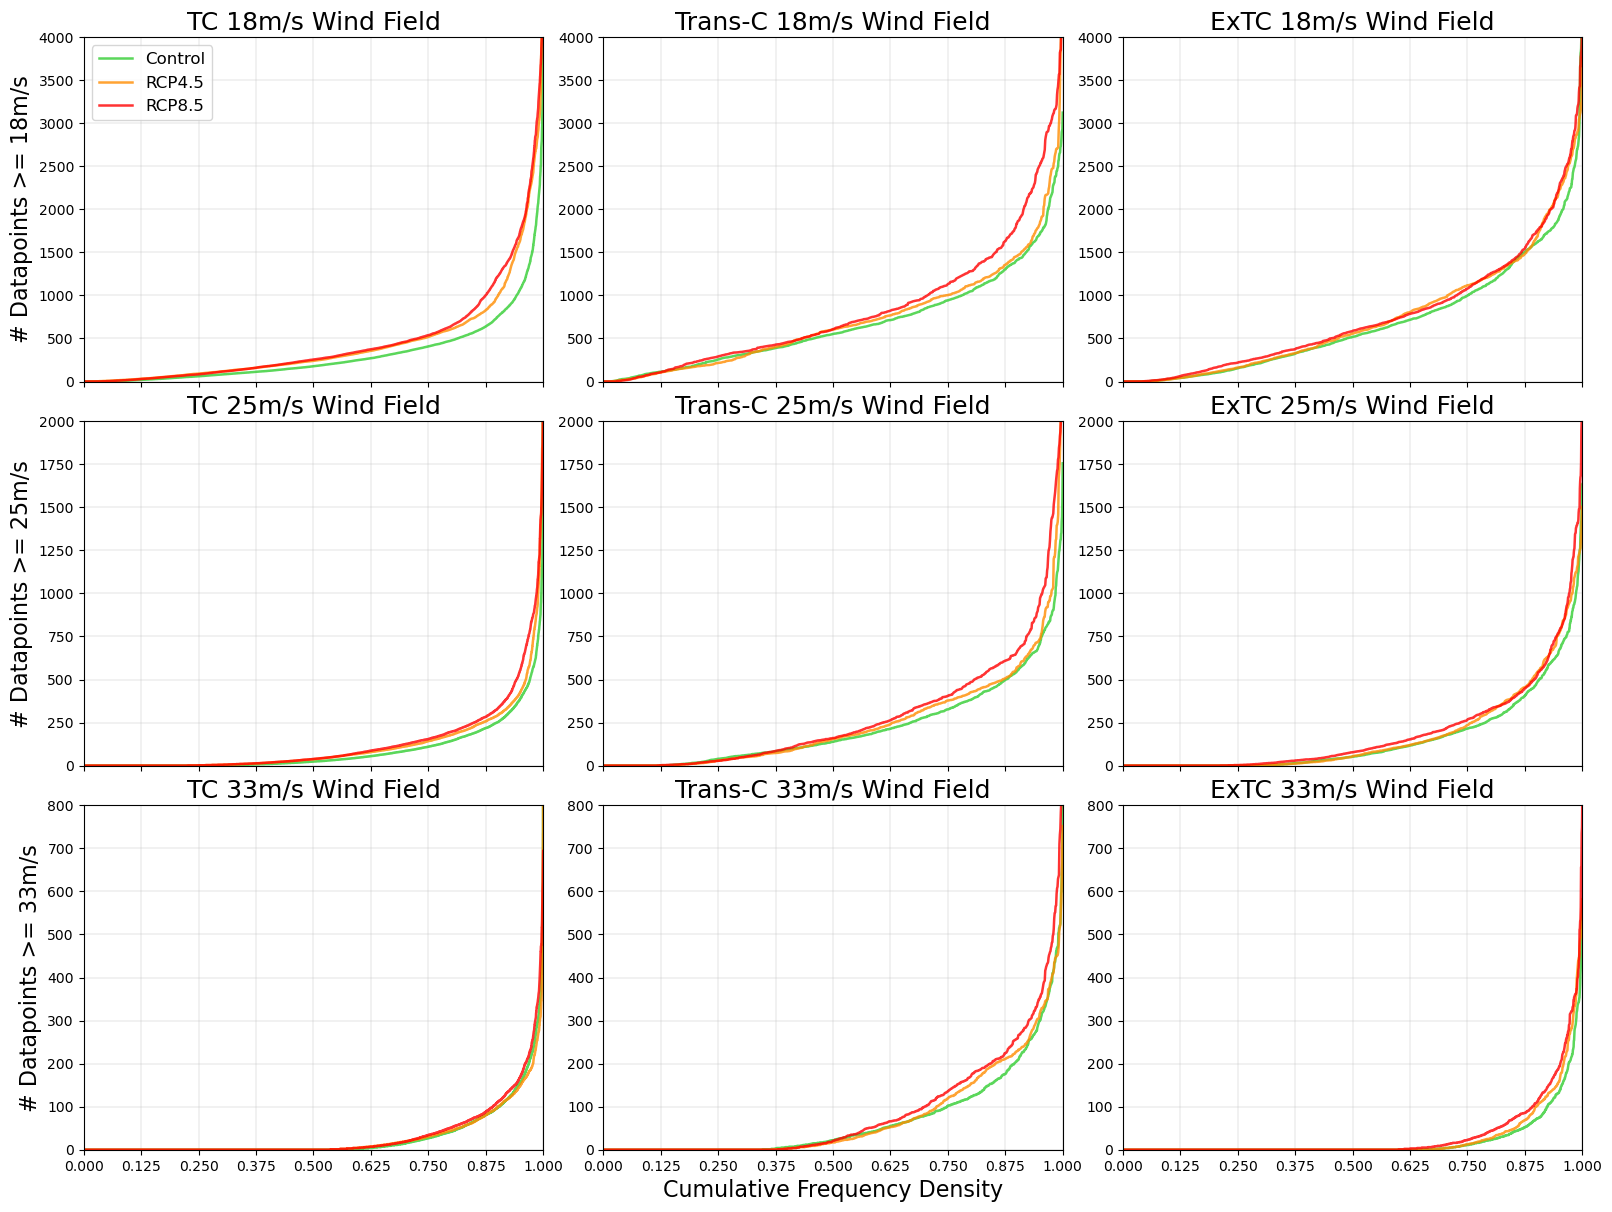

In [36]:
Cum_Dist_Plot(DF_Compo_Control, DF_Compo_RCP45, DF_Compo_RCP85, True)

In [37]:
# Find Wind Field Size at ET Begin and ET Complete
def ET_Wind_Field(DF_Compo, ET_DF):
    Codes_List = ET_DF["Code"]
    Start_Time = ET_DF["Start Time"]
    End_Time = ET_DF["End Time"]
    Start_Wind_18 = numpy.zeros(len(Codes_List))
    End_Wind_18 = numpy.zeros(len(Codes_List))
    for n in range(len(Codes_List)):
        DF_Compo_Start = DF_Compo[(DF_Compo["Code"] == Codes_List[n]) & (DF_Compo["Time"] == Start_Time[n])].reset_index()
        DF_Compo_End = DF_Compo[(DF_Compo["Code"] == Codes_List[n]) & (DF_Compo["Time"] == End_Time[n])].reset_index()
        if len(DF_Compo_Start) > 0:
            Start_Wind_18[n] = DF_Compo_Start["850hPa 18m/s"][0]
        else:
            Start_Wind_18[n] = numpy.nan
        if len(DF_Compo_End) > 0:
            End_Wind_18[n] = DF_Compo_End["850hPa 18m/s"][0]
        else:
            End_Wind_18[n] = numpy.nan
    ET_DF_New = ET_DF.copy()
    ET_DF_New["Start 18m/s"] = Start_Wind_18
    ET_DF_New["End 18m/s"] = End_Wind_18
    return (ET_DF_New)

In [38]:
Control_ET_Wind = ET_Wind_Field(DF_Compo_Control, Control_ET)
RCP45_ET_Wind = ET_Wind_Field(DF_Compo_RCP45, RCP45_ET)
RCP85_ET_Wind = ET_Wind_Field(DF_Compo_RCP85, RCP85_ET)
Control_ET_Wind

,Code,Name,Path Type,Start Time,End Time,Min SLP,Start SLP,End SLP,Start Lon,Start Lat,End Lon,End Lat,Start 18m/s,End 18m/s
0,TC190001,Alex,3,1900-07-03 18:00:00,1900-07-03 18:00:00,987.41,1015.57,1015.57,-90.75,36.25,-90.75,36.25,59.0,59.0
1,TC190003,Colin,1,1900-09-18 00:00:00,1900-09-20 12:00:00,934.83,952.06,979.68,-77.17,31.14,-62.68,47.61,370.0,1104.0
2,TC190004,Dawn,1,1900-11-05 12:00:00,1900-11-06 12:00:00,948.88,954.74,992.74,-87.08,27.00,-74.44,30.88,168.0,628.0
3,TC190005,Ernest,1,1900-11-06 00:00:00,1900-11-08 00:00:00,988.17,996.02,998.22,-27.73,41.42,-9.00,45.00,642.0,780.0
4,TC190102,Harrison,1,1901-05-28 12:00:00,1901-05-30 18:00:00,980.89,991.56,1008.78,-43.71,30.04,-34.75,24.00,140.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,TC198802,Micah,1,1988-02-06 00:00:00,1988-02-06 06:00:00,998.09,999.63,999.02,-31.01,38.29,-28.74,38.72,516.0,416.0
323,TC198805,Sabrina,1,1988-09-07 06:00:00,1988-09-08 12:00:00,980.43,984.68,987.91,-48.37,33.35,-35.17,42.45,544.0,869.0
324,TC198808,Alice,2,1988-09-12 06:00:00,1988-09-12 12:00:00,990.70,1009.08,1008.35,-39.50,44.00,-37.50,45.75,745.0,690.0
325,TC198809,Bruce,1,1988-09-21 06:00:00,1988-09-27 00:00:00,934.40,961.07,1001.36,-66.39,30.40,-41.00,47.00,242.0,699.0


In [260]:
# Plot 18m/s Wind Field at ET Start and ET End
def ET_Cum_Dist_Plot(Control_ET, RCP45_ET, RCP85_ET, Savefig):
    Fig = pyplot.figure(figsize=(16,8))
#
# Apply Cumulative Distribution Function
    Sorted_Start_1, Density_Start_1 = Cum_Dist(Control_ET["Start 18m/s"])
    Sorted_Start_2, Density_Start_2 = Cum_Dist(RCP45_ET["Start 18m/s"])
    Sorted_Start_3, Density_Start_3 = Cum_Dist(RCP85_ET["Start 18m/s"])
    Sorted_End_1, Density_End_1 = Cum_Dist(Control_ET["End 18m/s"])
    Sorted_End_2, Density_End_2 = Cum_Dist(RCP45_ET["End 18m/s"])
    Sorted_End_3, Density_End_3 = Cum_Dist(RCP85_ET["End 18m/s"])
#
# Plot ET Start 18m/s Wind Field
    Axis = Fig.add_subplot(1,2,1)
    Axis.plot(Density_Start_1, Sorted_Start_1, color='limegreen', linewidth=2.8, label='Control', alpha=0.8)
    Axis.plot(Density_Start_2, Sorted_Start_2, color='orange', linewidth=2.8, label='RCP4.5', alpha=0.8)
    Axis.plot(Density_Start_3, Sorted_Start_3, color='red', linewidth=2.8, label='RCP8.5', alpha=0.8)
    ET_Cum_Dist_Formatting(Axis, "ET Initiation")
#
# Plot ET End 18m/s Wind Field
    Axis = Fig.add_subplot(1,2,2)
    Axis.plot(Density_End_1, Sorted_End_1, color='limegreen', linewidth=2.8, label='Control', alpha=0.8)
    Axis.plot(Density_End_2, Sorted_End_2, color='orange', linewidth=2.8, label='RCP4.5', alpha=0.8)
    Axis.plot(Density_End_3, Sorted_End_3, color='red', linewidth=2.8, label='RCP8.5', alpha=0.8)
    ET_Cum_Dist_Formatting(Axis, "ET Completion")
    pyplot.legend(loc=2, fontsize=14)
#
# Savefig
    if Savefig == True:
        Figname = str('ET_Wind_Field_Cumulative.png')
        Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V5/'+Figname, bbox_inches='tight')

In [261]:
# Formatting Based on Variable
def ET_Cum_Dist_Formatting(Axis, Var):
    Axis.set_xticks(Create_Bins(0,1,0.125))
    Axis.set_xlim(0,1)
    Axis.set_yticks(Create_Bins(0,5000,500))
    Axis.set_ylim(0,5000)
    Axis.grid(linewidth=0.3, color="silver", linestyle="-")
    Axis.set_xlabel("Cumulative Frequency Density", fontsize=16)
    if Var == "ET Initiation":
        Axis.set_ylabel("# Datapoints >= 18m/s", fontsize=16)
    Title = str("18m/s Wind Field at " + Var)
    Axis.set_title(Title, fontsize=18)

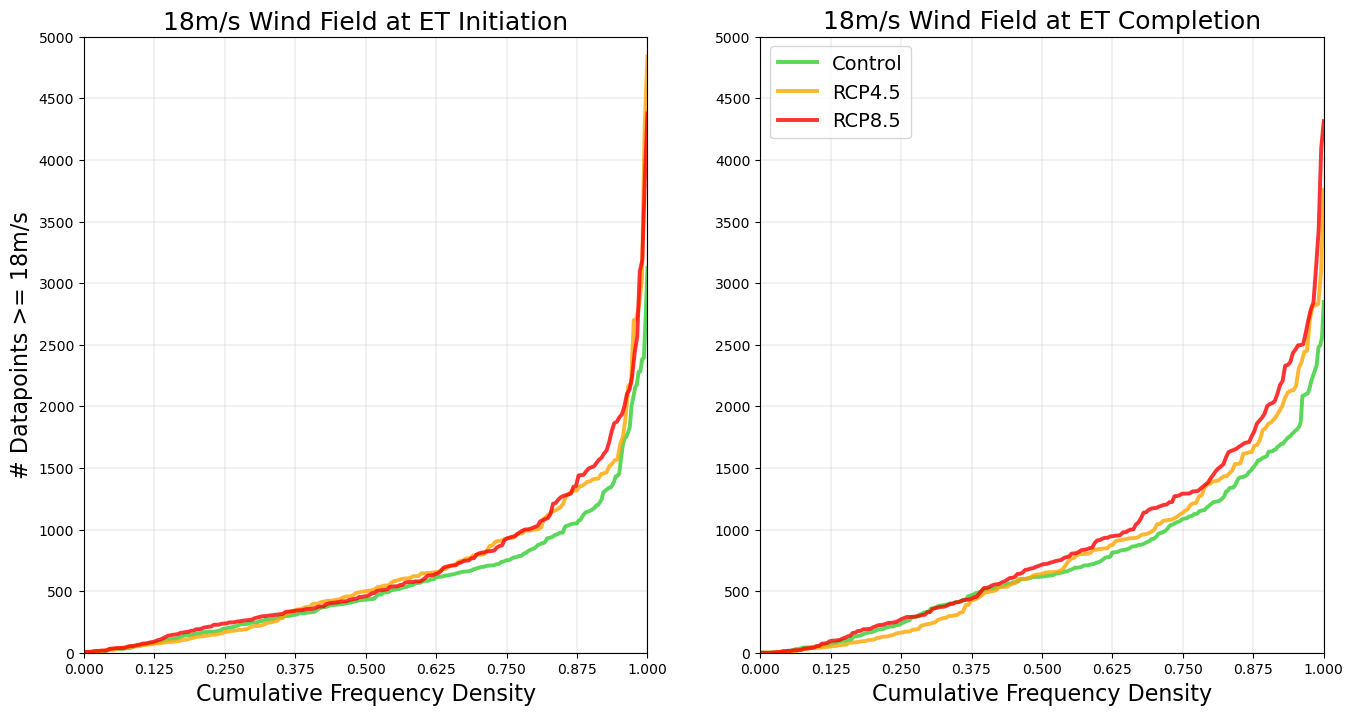

In [262]:
ET_Cum_Dist_Plot(Control_ET_Wind, RCP45_ET_Wind, RCP85_ET_Wind, True)

In [164]:
DF_Compo_Control

,Code,Compo Index,Time,Lon,Lat,SLP(hPa),Winds(m/s),B,VLT,VUT,Storm Phase,850hPa 18m/s,850hPa 25m/s,850hPa 33m/s
0,TC190001,0.0,1900-06-19 12:00:00,-82.19,27.99,1015.45,13.9,4.71,37.04,-36.64,Tropical,149.0,0.0,0.0
1,TC190001,1.0,1900-06-19 18:00:00,-82.26,27.79,1015.45,13.8,6.18,-12.97,-23.15,Tropical,69.0,0.0,0.0
2,TC190001,2.0,1900-06-20 00:00:00,-82.33,27.58,1015.45,13.7,3.28,-8.22,-18.60,Tropical,23.0,0.0,0.0
3,TC190001,3.0,1900-06-20 06:00:00,-82.40,27.38,1015.45,13.7,3.45,-0.38,-18.54,Tropical,21.0,0.0,0.0
4,TC190001,4.0,1900-06-20 12:00:00,-82.46,28.31,1014.22,11.7,1.72,8.23,-4.21,Tropical,13.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12588,TC198902,10447.0,1989-09-28 18:00:00,-5.25,46.00,1016.56,10.2,31.29,-180.49,-149.36,Extratropical,1.0,0.0,0.0
12589,TC198902,10448.0,1989-09-29 00:00:00,-2.50,46.00,1018.02,8.4,26.75,-192.50,-150.26,Extratropical,0.0,0.0,0.0
12590,TC198902,10449.0,1989-09-29 06:00:00,-1.50,46.25,1017.76,7.6,22.77,-200.64,-148.95,Extratropical,0.0,0.0,0.0
12591,TC198902,10450.0,1989-09-29 12:00:00,-0.25,47.00,1018.13,9.1,21.04,-202.06,-149.32,Extratropical,0.0,0.0,0.0


In [225]:
# Find Mean Wind Field Size of Each Gridbox in Phase Space Distribution
def Phase_Space_Distribution(DF, Var, VLT_Bins, B_Bins):
    VLT_B_Vals = []
    for j in range(len(VLT_Bins)-1):
        VLT_B_Vals.append([])
        for k in range(len(B_Bins)-1):
            VLT_B_Vals[j].append([])
    VLT_B_Median = numpy.zeros((len(VLT_Bins)-1, len(B_Bins)-1))
#
# Count Wind Field Size in Phase Space Distribution
    Values = DF[Var]
    for i in range(len(Values)):
        for j in range(len(VLT_Bins)-1):
            if DF["VLT"][i] > VLT_Bins[j] and DF["VLT"][i] <= VLT_Bins[j+1]:
                for k in range(len(B_Bins)-1):
                    if DF["B"][i] > B_Bins[k] and DF["B"][i] <= B_Bins[k+1]:
                        VLT_B_Vals[j][k].append(Values[i])
#
# Calculate Mean Wind Field Size
    for j in range(len(VLT_Bins)-1):
        for k in range(len(B_Bins)-1):
            if len(VLT_B_Vals[j][k]) >= 5:
                VLT_B_Median[j][k] = numpy.median(VLT_B_Vals[j][k])
            else:
                VLT_B_Median[j][k] = 0
    return (VLT_B_Median)

In [226]:
VLT_Bins = Create_Bins(-600,600,100)
B_Bins = Create_Bins(-45,135,15)
Bins_Bounds = numpy.array([-600,600,100,-45,135,15])

In [227]:
Control_Phase_18ms = Phase_Space_Distribution(DF_Compo_Control, "850hPa 18m/s", VLT_Bins, B_Bins)
RCP45_Phase_18ms = Phase_Space_Distribution(DF_Compo_RCP45, "850hPa 18m/s", VLT_Bins, B_Bins)
RCP85_Phase_18ms = Phase_Space_Distribution(DF_Compo_RCP85, "850hPa 18m/s", VLT_Bins, B_Bins)
Control_Phase_Winds = Phase_Space_Distribution(DF_Compo_Control, "Winds(m/s)", VLT_Bins, B_Bins)
RCP45_Phase_Winds = Phase_Space_Distribution(DF_Compo_RCP45, "Winds(m/s)", VLT_Bins, B_Bins)
RCP85_Phase_Winds = Phase_Space_Distribution(DF_Compo_RCP85, "Winds(m/s)", VLT_Bins, B_Bins)

In [233]:
# Create Function For Colours
Wind_Field_Colours = ['limegreen', 'greenyellow', 'yellow', 'gold', 'orange', 'darkorange', 'red']
Wind_Field_Bounds = numpy.array([0,100,250,500,750,1000,1500])
Wind_Field_Spatial_Bounds = numpy.array([0,100,250,500,750,1000,1500])
# Create Function For Colours
def Dist_Colour(Density, Dist_Colours, Dist_Bounds):
    for k in range(len(Dist_Colours)):
        if Density == 0:
            Colour = 'white'
        else:
            if k != len(Dist_Colours)-1:
                if Density <= Dist_Bounds[k+1] and Density > Dist_Bounds[k]:
                    Colour = Dist_Colours[k]
            else:
                if Density > Dist_Bounds[k]:
                    Colour = Dist_Colours[k]
    return (Colour)

In [229]:
# Plot Cyclone Phase Distribution
def Cyclone_Phase_Var_Dist_Plot(Axis, Values, VLT_Bins, B_Bins, Bounds, Colours, Model, Var):
# VLT B Distribution
    Axis = Fig.add_subplot(1,1,1)
    for j in range(len(Values)):
        for k in range(len(Values[0])):
            Colour = Dist_Colour(Values[j][k], Colours, Bounds)
            pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], B_Bins[k], B_Bins[k+1], color=Colour)
# Formatting
    x_Axis = Create_Bins(Bins_Bounds[0],Bins_Bounds[1],100)
    y_Axis = Create_Bins(Bins_Bounds[3],Bins_Bounds[4],15)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(Bins_Bounds[0],Bins_Bounds[1])
    pyplot.ylim(Bins_Bounds[3],Bins_Bounds[4])
    pyplot.plot([-1000,1000], [15,15], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-150,300], 'black', linewidth=0.5)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('B', fontsize=12)
    Title = str(Var + " on " + Model + " Phase Space")
    pyplot.title(Title, fontsize=14)
#
# Colour Bar
    Cbar_Label = "18m/s Wind Field Size"
    C_Map = mcolors.LinearSegmentedColormap.from_list("18m/s Wind Field Size", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='max')
    Cax = Axis.inset_axes([0.1, -0.12, 0.8, 0.02], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, \
    label=Cbar_Label, ticks=Bounds, shrink=0.7)

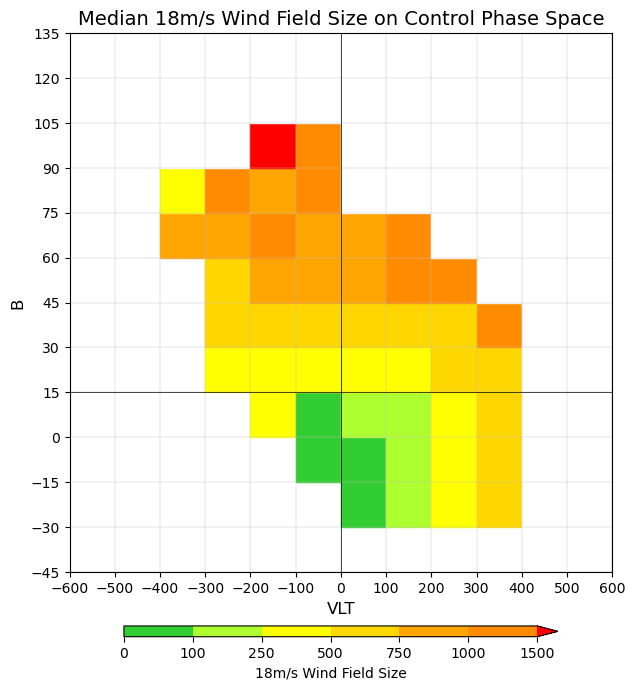

In [230]:
Fig = pyplot.figure(figsize=(7,7))
Cyclone_Phase_Var_Dist_Plot(Axis, Control_Phase_18ms, VLT_Bins, B_Bins, Wind_Field_Bounds, Wind_Field_Colours, \
"Control", "Median 18m/s Wind Field Size")

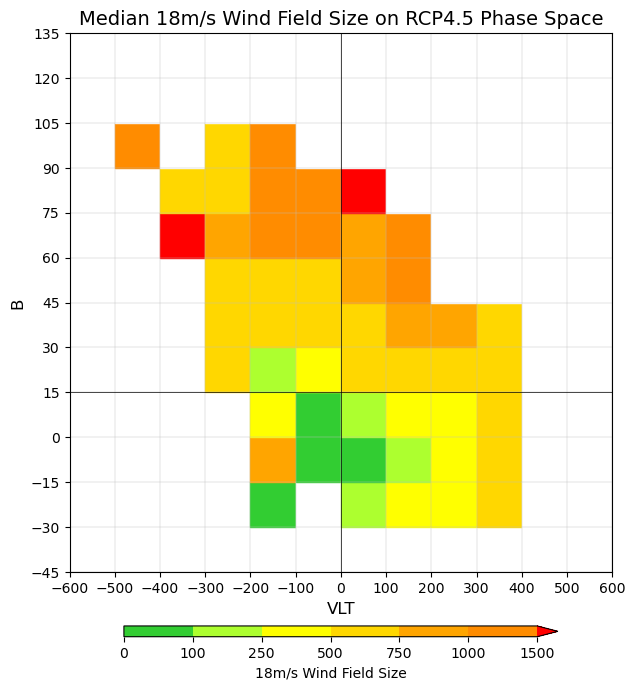

In [231]:
Fig = pyplot.figure(figsize=(7,7))
Cyclone_Phase_Var_Dist_Plot(Axis, RCP45_Phase_18ms, VLT_Bins, B_Bins, Wind_Field_Bounds, Wind_Field_Colours, \
"RCP4.5", "Median 18m/s Wind Field Size")

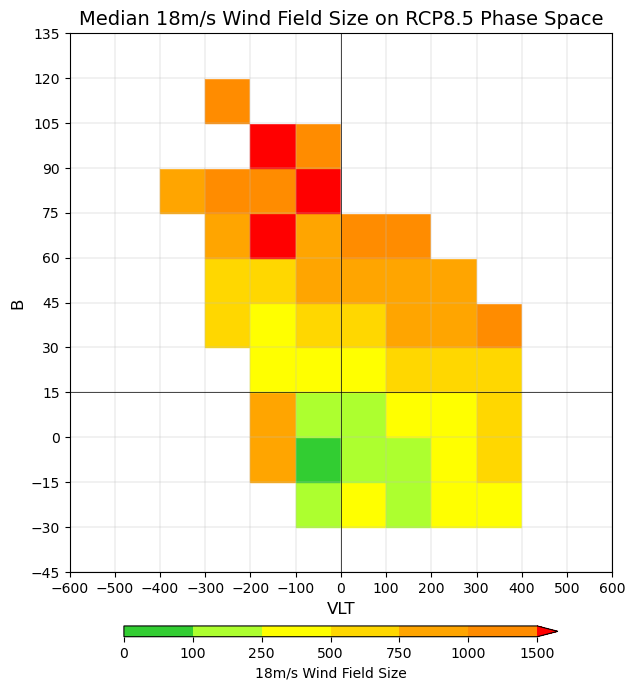

In [232]:
Fig = pyplot.figure(figsize=(7,7))
Cyclone_Phase_Var_Dist_Plot(Axis, RCP85_Phase_18ms, VLT_Bins, B_Bins, Wind_Field_Bounds, Wind_Field_Colours, \
"RCP8.5", "Median 18m/s Wind Field Size")

In [243]:
# Find Mean Wind Field Size of Each Gridbox in Spatial Distribution
def ET_Locations_Distribution(DF, Var, Lon_Bins, Lat_Bins):
    Lat_Lon_Vals = []
    for j in range(len(Lat_Bins)-1):
        Lat_Lon_Vals.append([])
        for k in range(len(Lon_Bins)-1):
            Lat_Lon_Vals[j].append([])
    Lat_Lon_Median = numpy.zeros((len(Lat_Bins)-1, len(Lon_Bins)-1))
#
# Count Lat Lon Distribution in Each Gridbox
    Values = DF[Var]
    for i in range(len(Values)):
        for j in range(len(Lat_Bins)-1):
            if DF["Lat"][i] >= (Lat_Bins[j]-5) and DF["Lat"][i] <= (Lat_Bins[j+1]+5):
                for k in range(len(Lon_Bins)-1):
                    if DF["Lon"][i] >= (Lon_Bins[k]-5) and DF["Lon"][i] <= (Lon_Bins[k+1]+5):
                        Lat_Lon_Vals[j][k].append(Values[i])
# Calculate Mean Wind Field Size
    for j in range(len(Lat_Bins)-1):
        for k in range(len(Lon_Bins)-1):
            if len(Lat_Lon_Vals[j][k]) >= 5:
                Lat_Lon_Median[j][k] = numpy.median(Lat_Lon_Vals[j][k])
            else:
                Lat_Lon_Median[j][k] = 0
    return (Lat_Lon_Median)

In [177]:
Lon_Bins = Create_Bins(-100,20,5)
Lat_Bins = Create_Bins(10,60,5)

In [247]:
Control_Spatial_18ms = ET_Locations_Distribution(DF_Compo_Control, "850hPa 18m/s", Lon_Bins, Lat_Bins)
RCP45_Spatial_18ms = ET_Locations_Distribution(DF_Compo_RCP45, "850hPa 18m/s", Lon_Bins, Lat_Bins)
RCP85_Spatial_18ms = ET_Locations_Distribution(DF_Compo_RCP85, "850hPa 18m/s", Lon_Bins, Lat_Bins)
#Control_Spatial_18ms

In [236]:
# Plot Spatial Distribution
def Spatial_Var_Dist_Plot(Axis, Values, Lon_Bins, Lat_Bins, Bounds, Colours, Model, Var):
# VLT B Distribution
    Axis = Fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
    for j in range(len(Values)):
        for k in range(len(Values[0])):
            Colour = Dist_Colour(Values[j][k], Colours, Bounds)
            pyplot.fill_between([Lon_Bins[k], Lon_Bins[k+1]], Lat_Bins[j], Lat_Bins[j+1], color=Colour)
# Formatting
    Axis.coastlines(linewidth=0.5)
    Axis.add_feature(cfeature.BORDERS, linewidth=0.5)
    Axis.add_feature(cfeature.STATES, linewidth=0.3)
    x_Axis = Create_Bins(-100,20,10)
    y_Axis = Create_Bins(10,60,10)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-100,20)
    pyplot.ylim(10,60)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    Title = str(Var + " on " + Model + " Spatial Distribution")
    pyplot.title(Title, fontsize=14)
#
# Colour Bar
    Cbar_Label = "18m/s Wind Field Size"
    C_Map = mcolors.LinearSegmentedColormap.from_list("18m/s Wind Field Size", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='max')
    Cax = Axis.inset_axes([0.2, -0.12, 0.6, 0.03], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, \
    label=Cbar_Label, ticks=Bounds, shrink=0.7)

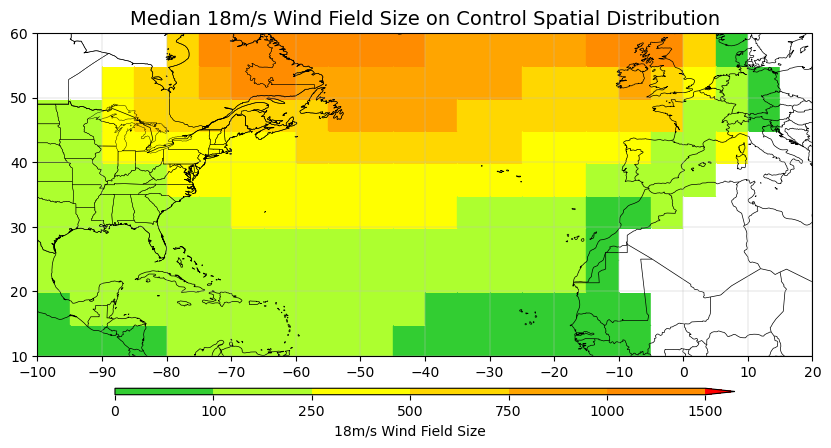

In [257]:
Fig = pyplot.figure(figsize=(10,5))
Spatial_Var_Dist_Plot(Axis, Control_Spatial_18ms, Lon_Bins, Lat_Bins, \
Wind_Field_Spatial_Bounds, Wind_Field_Colours, "Control", "Median 18m/s Wind Field Size")

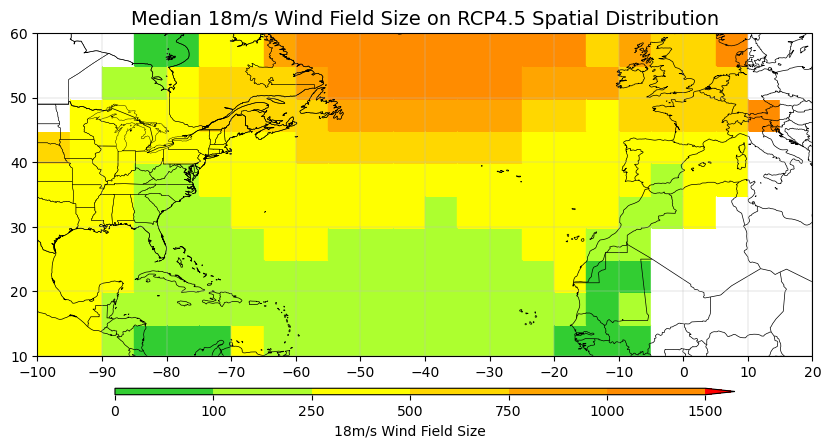

In [258]:
Fig = pyplot.figure(figsize=(10,5))
Spatial_Var_Dist_Plot(Axis, RCP45_Spatial_18ms, Lon_Bins, Lat_Bins, \
Wind_Field_Spatial_Bounds, Wind_Field_Colours, "RCP4.5", "Median 18m/s Wind Field Size")

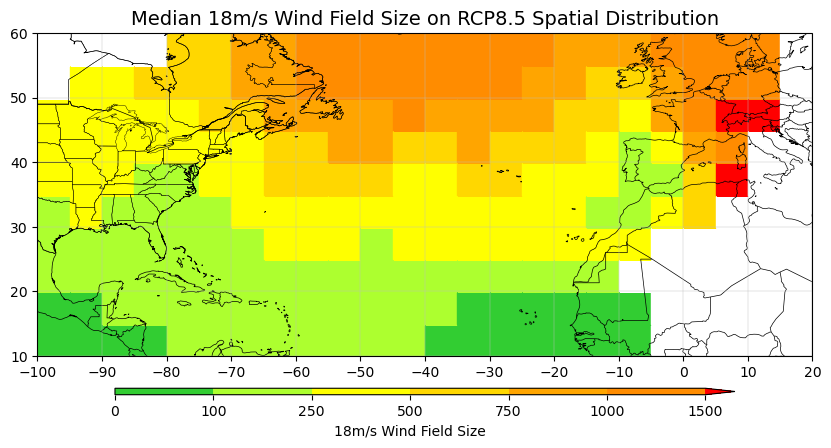

In [259]:
Fig = pyplot.figure(figsize=(10,5))
Spatial_Var_Dist_Plot(Axis, RCP85_Spatial_18ms, Lon_Bins, Lat_Bins, \
Wind_Field_Spatial_Bounds, Wind_Field_Colours, "RCP8.5", "Median 18m/s Wind Field Size")

In [44]:
# Output Data
def Output_File(DF, Model):
    File_Name = str(Model+'_Wind_Field_Info.csv')
    Output_Diri = '/glade/u/home/whimkao//ExtraTrack/Output_Files_V5.4/'
    DF.to_csv(Output_Diri+File_Name)

In [45]:
Output_File(DF_Compo_Control, "Control")
Output_File(DF_Compo_RCP45, "RCP4.5")
Output_File(DF_Compo_RCP85, "RCP8.5")